At the end of the experiment:

1. Understand the role of optimizer(Adam) in neural networks
2. Tune the Adam optimizer to obtain better model


The dataset used for this experiment is CIFAR-100. It  has 100 classes which contains 600 images for each class. There are 500 training images and 100 testing images per class. These 100 classes are grouped into 20 superclasses. Each image comes with the class and superclass it belongs to.

Here is the list of classes in the CIFAR-100:

| Superclass 	 | Classes|
|--------------------|-------------|
|aquatic mammals | 	beaver, dolphin, otter, seal, whale |
|fish |	aquarium fish, flatfish, ray, shark, trout |
|flowers| 	orchids, poppies, roses, sunflowers, tulips |
|food containers| 	bottles, bowls, cans, cups, plates|
|fruit and vegetables| 	apples, mushrooms, oranges, pears, sweet peppers|
|household electrical devices | clock, computer keyboard, lamp, telephone, television|
|household furniture| 	bed, chair, couch, table, wardrobe|
|insects | 	bee, beetle, butterfly, caterpillar, cockroach |
|large carnivores| 	bear, leopard, lion, tiger, wolf|
|large man-made outdoor things |	bridge, castle, house, road, skyscraper|
|large natural outdoor scenes |	cloud, forest, mountain, plain, sea|
|large omnivores and herbivores |	camel, cattle, chimpanzee, elephant, kangaroo|
|medium-sized mammals |	fox, porcupine, possum, raccoon, skunk|
|non-insect invertebrates|	crab, lobster, snail, spider, worm|
|people| 	baby, boy, girl, man, woman|
|reptiles |	crocodile, dinosaur, lizard, snake, turtle|
|small mammals| 	hamster, mouse, rabbit, shrew, squirrel |
|trees|	maple, oak, palm, pine, willow |
|vehicles 1 |	bicycle, bus, motorcycle, pickup truck, train |
|vehicles 2 |	lawn-mower, rocket, streetcar, tank, tractor |



The dataset is downloaded from following url :

https://www.cs.toronto.edu/~kriz/cifar.html

**Importing required Packages**

In [ ]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
# Checking for GPU instance
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Intilizaing the accuracy value as zero
best_acc = 0

#### Data Preparation

In [ ]:
print('\n[Phase 1] : Data Preparation')

##dataset
dataset = 'cifar100'

# Preparing the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
]) # meanstd transformation


[Phase 1] : Data Preparation


In [ ]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
])

In [ ]:
# number of classes in the dataset
num_classes = 100

In [ ]:
### Downloading the dataset
trainset = torchvision.datasets.CIFAR100(root='data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='data', train=False, download=False, transform=transform_test)
### Loading the dataset 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)


Extracting data/cifar-100-python.tar.gz to data


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

        
class LeNet(nn.Module):
    def __init__(self, num_classes, init_mode='xavier'):  ### supports 'zero', 'normal', 'xavier', 'he' inits
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
        
        if init_mode == 'zero':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.zero_()   ### fill tensor elements with zeros
                    if m.bias is not None:
                        m.bias.data.zero_()
        
        if init_mode == 'normal':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.normal_()   ### fill tensor elements with random numbers from normal distribution
                    if m.bias is not None:
                        m.bias.data.normal_()
        
        if init_mode == 'xavier':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                    n = fan_in + fan_out
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # number of rows
                    fan_in = size[1] # number of columns
                    variance = math.sqrt(2.0/(fan_in+fan_out))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
        
        if init_mode == 'he':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # number of rows
                    fan_in = size[1] # number of columns
                    variance = math.sqrt(2.0/(fan_in))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
                
                
    ## Forward Pass
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return(out)

### Training with Xavier init

In [ ]:
## Calling the model
net = LeNet(num_classes, init_mode='xavier')
# Checking for GPU instance
net = net.to(device)

In [ ]:
### Intiliazing the loss
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    # Declaring the values
    train_loss = 0
    correct = 0
    total = 0
    # Looping over Train data
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Checking for GPU instance
        #if use_cuda:
        inputs, targets = inputs.to(device), targets.to(device)
        # Optimizer
        optimizer.zero_grad()
        # Converting inputs and targets into pytorch variables 
       # inputs, targets = Variable(inputs), Variable(targets)
        # Forward Pass
        outputs = net(inputs)
        # Storing the outputs size
        size_ = outputs.size()
        # Reducing the outputs dimenssion
        outputs_ = outputs.view(size_[0], num_classes)
        # Calculating the loss
        loss = criterion(outputs_, targets)
        # Backward Pass
        loss.backward()
        # Optimizer Steps
        optimizer.step()
        # Calculating the train data
        train_loss += loss.item()
        # Predicting the values
        _, predicted = torch.max(outputs_.data, 1)
        # Storing the targets size
        total += targets.size(0)
        # Calculating the correct values
        correct += predicted.eq(targets.data).cpu().sum().item()
        # Printing the data
        if batch_idx%30 == 0 or batch_idx == len(trainloader)-1:
            # Printing the progress bar
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Storing the epoch,loss and accuracy into a file
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [ ]:
def test(epoch):
    global best_acc
    net.eval()
    # Declaring the values
    test_loss = 0
    correct = 0
    total = 0
    # Looping over the test data
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # Checking for GPU instance
        #if use_cuda:
        inputs, targets = inputs.to(device), targets.to(device)
        # Converting inputs and targets into pytorch variables 
        #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        # Forward Pass
        outputs = net(inputs)
        # Storing the outputs size
        size_ = outputs.size()
        # Reducing the dimenssion
        outputs_ = outputs.view(size_[0], num_classes)
        # Calculating the loss
        loss = criterion(outputs_, targets)
        # Storing the sum of loss 
        test_loss += loss.item()
        # Storing the predicted values
        _, predicted = torch.max(outputs_.data, 1)
        # Storing the targets size
        total += targets.size(0)
        # Calcualting the correct values
        correct += predicted.eq(targets.data).cpu().sum().item()
        # Printing the data
        if batch_idx%30 == 0 or batch_idx == len(testloader)-1:
            # Printing the progress bar
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Printing the validation loss
    print('val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total)
    # Storing epoch,loss and accuracy into a file
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    # Checking for best accuracy
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net,
            'acc': acc,
            'epoch': epoch,
        }
        # Checking whether its a directory or not
        if not os.path.isdir('../checkpoint'):
            # Creating a directory
            os.mkdir('../checkpoint')
        # Saving the data
        torch.save(state, '../checkpoint_ckpt.t7')
        # Storing the accuracy
        best_acc = acc

In [ ]:
experiment = 'adam_solver'
# Creating files in write mode
train_loss_file = open(experiment+"train_loss.txt", "w")
val_loss_file = open(experiment+"val_loss.txt", "w")

In [ ]:
# Training and Testing the model for 60 epochs
for epoch in range(0, 60):
    if epoch == 50:
        optimizer = optim.Adam(net.parameters(), lr=0.00001)
    if epoch == 30:
        optimizer = optim.Adam(net.parameters(), lr=0.0001)
    if epoch == 0:
        optimizer = optim.Adam(net.parameters(), lr=0.001)
    # Training the model
    train(epoch)
    # Testing the model
    test(epoch)
# Closing the files
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 4.098 | Acc: 7.798% (3899/50000)  391/391 
 [==================================>] | Loss: 3.714 | Acc: 13.450% (1345/10000) 100/100 
val_loss:  3.713619205951691 accuracy:  13.45
Saving..

Epoch: 1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 [==================================>] | Loss: 3.645 | Acc: 14.392% (7196/50000) 391/391 
 [==================================>] | Loss: 3.445 | Acc: 18.030% (1803/10000) 100/100 
val_loss:  3.445308063030243 accuracy:  18.03
Saving..

Epoch: 2
 [==================================>] | Loss: 3.434 | Acc: 17.946% (8973/50000) 391/391 
 [==================================>] | Loss: 3.298 | Acc: 20.890% (2089/10000) 100/100 
val_loss:  3.298041617870331 accuracy:  20.89
Saving..

Epoch: 3
 [==================================>] | Loss: 3.308 | Acc: 20.000% (10000/50000) 391/391 
 [==================================>] | Loss: 3.158 | Acc: 23.020% (2302/10000)

#### Plotting the training curves

60 60


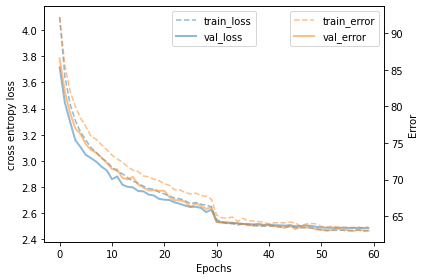

In [ ]:
training_curves(experiment)